In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

import math

In [4]:
class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        base_activation=torch.nn.SiLU,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )

        self.scale_noise = scale_noise
        self.base_activation = base_activation()

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5))
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output

        output = output.view(*original_shape[:-1], self.out_features)
        return output

In [5]:
class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        base_activation=torch.nn.SiLU,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    base_activation=base_activation,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            x = layer(x)
        return x

In [6]:
# Load and preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 58898035.88it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1875659.13it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 14183243.57it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6407846.88it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
# Model params
input_dim = 28 * 28  # MNIST images are 28x28 pixels
hidden_dim = 128
output_dim = 10  # 10 classes for the digits 0-9

In [8]:
model = KAN([input_dim, hidden_dim, output_dim])
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [9]:
# Training loop
epochs = 2
for epoch in range(epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(-1, 28 * 28)  # Flatten the images
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print(f'Train Epoch: {epoch+1} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.272752
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.470768
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.439565
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.265131
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.127759
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.173039
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.198989
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.188573
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.034794
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.097822


In [10]:
# Testing the KAN
model.eval()
test_loss = 0
correct = 0
correct_predictions = []
incorrect_predictions = []
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(-1, 28 * 28)  # Flatten the images
        output = model(data)
        test_loss += criterion(output, target).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        # Collect predictions for visualization
        softmax_output = F.softmax(output, dim=1)
        for i in range(len(data)):
            true_label = target[i].item()
            predicted_label = pred[i].item()
            prediction_confidence = softmax_output[i][predicted_label].item()
            true_label_confidence = softmax_output[i][true_label].item()
            if predicted_label == true_label:
                correct_predictions.append((data[i].view(28, 28), predicted_label, prediction_confidence, true_label, true_label_confidence))
            else:
                incorrect_predictions.append((data[i].view(28, 28), predicted_label, prediction_confidence, true_label, true_label_confidence))

test_loss /= len(test_loader.dataset)
accuracy = correct / len(test_loader.dataset)

print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * accuracy:.2f}%)\n')


Test set: Average loss: 0.0001, Accuracy: 9618/10000 (96.18%)



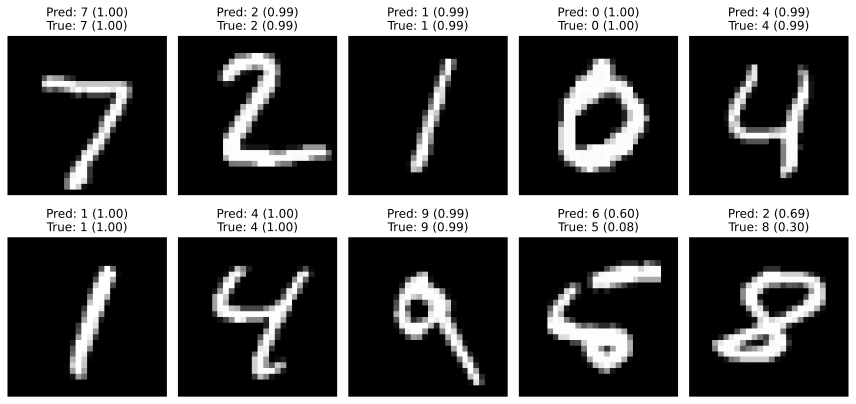

In [11]:
# Visualize 10 predictions
num_correct = 8
num_incorrect = 2
plt.figure(figsize=(12, 6))

# Plot correct predictions
for i in range(num_correct):
    plt.subplot(2, 5, i + 1)
    image, pred, pred_conf, true_label, true_label_conf = correct_predictions[i]
    plt.imshow(image, cmap='gray')
    plt.title(f'Pred: {pred} ({pred_conf:.2f})\nTrue: {true_label} ({true_label_conf:.2f})')
    plt.axis('off')

# Plot incorrect predictions
for i in range(num_incorrect):
    plt.subplot(2, 5, num_correct + i + 1)
    image, pred, pred_conf, true_label, true_label_conf = incorrect_predictions[i]
    plt.imshow(image, cmap='gray')
    plt.title(f'Pred: {pred} ({pred_conf:.2f})\nTrue: {true_label} ({true_label_conf:.2f})')
    plt.axis('off')

plt.tight_layout()
# plt.savefig('results.png', dpi=300)
plt.show()